# SSAST for speech

All functions copied from this repo and then edited as indicated

https://github.com/YuanGongND/ssast

I previously tried to completely 'serialize' the functions so they can be traced with torch for feature extraction, but I haven't been succesfuly in that (yet!)

Because I want this notebook to be self-contained it is long and ugly
* I import things in the block where the function or object is defined, instead of at the top, so it can more easily be turned back into .py files
* I use some fake args for the same reason

___

The first few things we need
* create a json from wav files in a folder/set of folders
* define a loader using torch audio. We will also save the filenames to make it easier to save embeddings

In [1]:
# prepare mayo speech data for ssl pretraining
import os,torchaudio,pickle,json,time

def walk(path, name, label_csv=None):
    sample_cnt = 0
    pathdata = os.walk(path)
    wav_list = []
    begin_time = time.time()
    for root, dirs, files in pathdata:
        for file in files:
            if file.endswith('.wav'):
                sample_cnt += 1

                cur_path = root + os.sep + file
                # give a dummy label of 'speech' ('/m/09x0r' in AudioSet label ontology) to all librispeech samples
                # the label is not used in the pretraining, it is just to make the dataloader.py satisfy.
                if label_csv==None:
                    label='/m/09x0r'
                
                #read label
                    
                
                cur_dict = {"wav": cur_path, "labels": label, "filename": file}
                wav_list.append(cur_dict)

                if sample_cnt % 1000 == 0:
                    end_time = time.time()
                    print('find {:d}k .wav files, time eclipse: {:.1f} seconds.'.format(int(sample_cnt/1000), end_time-begin_time))
                    begin_time = end_time
                if sample_cnt % 1e4 == 0:
                    with open(name + '.json', 'w') as f:
                        json.dump({'data': wav_list}, f, indent=1)
                    print('file saved.')
    print(sample_cnt)
    with open(name + '.json', 'w') as f:
        json.dump({'data': wav_list}, f, indent=1)


In [2]:
mayo_path = '/home/jupyter/mayo_legacy/mayo_legacy'
walk(mayo_path, 'mayo_legacy_all') # this saves in the current directory obv

find 1k .wav files, time eclipse: 0.0 seconds.
find 2k .wav files, time eclipse: 0.0 seconds.
find 3k .wav files, time eclipse: 0.0 seconds.
find 4k .wav files, time eclipse: 0.0 seconds.
find 5k .wav files, time eclipse: 0.0 seconds.
find 6k .wav files, time eclipse: 0.0 seconds.
find 7k .wav files, time eclipse: 0.0 seconds.
find 8k .wav files, time eclipse: 0.0 seconds.
find 9k .wav files, time eclipse: 0.0 seconds.
find 10k .wav files, time eclipse: 0.0 seconds.
file saved.
find 11k .wav files, time eclipse: 0.1 seconds.
find 12k .wav files, time eclipse: 0.0 seconds.
find 13k .wav files, time eclipse: 0.0 seconds.
find 14k .wav files, time eclipse: 0.0 seconds.
find 15k .wav files, time eclipse: 0.0 seconds.
find 16k .wav files, time eclipse: 0.0 seconds.
find 17k .wav files, time eclipse: 0.0 seconds.
find 18k .wav files, time eclipse: 0.0 seconds.
find 19k .wav files, time eclipse: 0.0 seconds.
find 20k .wav files, time eclipse: 0.0 seconds.
file saved.
20923


In [1]:
import csv
import json
import torchaudio
import numpy as np
import torch
import torch.nn.functional
from torch.utils.data import Dataset
import random

def make_index_dict(label_csv):
    index_lookup = {}
    with open(label_csv, 'r') as f:
        csv_reader = csv.DictReader(f)
        line_count = 0
        for row in csv_reader:
            index_lookup[row['mid']] = row['index']
            line_count += 1
    return index_lookup

def make_name_dict(label_csv):
    name_lookup = {}
    with open(label_csv, 'r') as f:
        csv_reader = csv.DictReader(f)
        line_count = 0
        for row in csv_reader:
            name_lookup[row['index']] = row['display_name']
            line_count += 1
    return name_lookup

def lookup_list(index_list, label_csv):
    label_list = []
    table = make_name_dict(label_csv)
    for item in index_list:
        label_list.append(table[item])
    return label_list

def preemphasis(signal,coeff=0.97):
    """perform preemphasis on the input signal.
    :param signal: The signal to filter.
    :param coeff: The preemphasis coefficient. 0 is none, default 0.97.
    :returns: the filtered signal.
    """
    return np.append(signal[0],signal[1:]-coeff*signal[:-1])

class AudioDataset(Dataset):
    def __init__(self, dataset_json_file, audio_conf, label_csv=None):
        """
        Dataset that manages audio recordings
        :param audio_conf: Dictionary containing the audio loading and preprocessing settings
        :param dataset_json_file
        """
        self.datapath = dataset_json_file
        with open(dataset_json_file, 'r') as fp:
            data_json = json.load(fp)

        self.data = data_json['data']
        self.audio_conf = audio_conf
        print('---------------the {:s} dataloader---------------'.format(self.audio_conf.get('mode')))
        self.melbins = self.audio_conf.get('num_mel_bins')
        self.freqm = self.audio_conf.get('freqm')
        self.timem = self.audio_conf.get('timem')
        print('now using following mask: {:d} freq, {:d} time'.format(self.audio_conf.get('freqm'), self.audio_conf.get('timem')))
        self.mixup = self.audio_conf.get('mixup')
        print('now using mix-up with rate {:f}'.format(self.mixup))
        self.dataset = self.audio_conf.get('dataset')
        print('now process ' + self.dataset)
        # dataset spectrogram mean and std, used to normalize the input
        self.norm_mean = self.audio_conf.get('mean')
        self.norm_std = self.audio_conf.get('std')
        # skip_norm is a flag that if you want to skip normalization to compute the normalization stats using src/get_norm_stats.py, if Ture, input normalization will be skipped for correctly calculating the stats.
        # set it as True ONLY when you are getting the normalization stats.
        self.skip_norm = self.audio_conf.get('skip_norm') if self.audio_conf.get('skip_norm') else False
        if self.skip_norm:
            print('now skip normalization (use it ONLY when you are computing the normalization stats).')
        else:
            print('use dataset mean {:.3f} and std {:.3f} to normalize the input.'.format(self.norm_mean, self.norm_std))
        # if add noise for data augmentation
        self.noise = self.audio_conf.get('noise')
        if self.noise == True:
            print('now use noise augmentation')

        self.index_dict = make_index_dict(label_csv)
        self.label_num = len(self.index_dict)
        print('number of classes is {:d}'.format(self.label_num))

    def _wav2fbank(self, filename, filename2=None):
        # mixup
        if filename2 == None:
            waveform, sr = torchaudio.load(filename)
            #waveform=waveform[0] ### added
            waveform = waveform - waveform.mean()
        # mixup
        else:
            waveform1, sr = torchaudio.load(filename)
            waveform2, _ = torchaudio.load(filename2)
            
            #waveform1=waveform1[0] ### added

            waveform1 = waveform1 - waveform1.mean()
            waveform2 = waveform2 - waveform2.mean()

            if waveform1.shape[1] != waveform2.shape[1]:
                if waveform1.shape[1] > waveform2.shape[1]:
                    # padding
                    temp_wav = torch.zeros(1, waveform1.shape[1])
                    temp_wav[0, 0:waveform2.shape[1]] = waveform2
                    waveform2 = temp_wav
                else:
                    # cutting
                    waveform2 = waveform2[0, 0:waveform1.shape[1]]

            # sample lambda from uniform distribution
            #mix_lambda = random.random()
            # sample lambda from beta distribtion
            mix_lambda = np.random.beta(10, 10)

            mix_waveform = mix_lambda * waveform1 + (1 - mix_lambda) * waveform2
            waveform = mix_waveform - mix_waveform.mean()

        fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                                                  window_type='hanning', num_mel_bins=self.melbins, dither=0.0, frame_shift=10)

        target_length = self.audio_conf.get('target_length')
        n_frames = fbank.shape[0]

        p = target_length - n_frames

        # cut and pad
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:target_length, :]

        if filename2 == None:
            return fbank, 0
        else:
            return fbank, mix_lambda

    def __getitem__(self, index):
        """
        returns: image, audio, nframes
        where image is a FloatTensor of size (3, H, W)
        audio is a FloatTensor of size (N_freq, N_frames) for spectrogram, or (N_frames) for waveform
        nframes is an integer
        """
        # do mix-up for this sample (controlled by the given mixup rate)
        if random.random() < self.mixup:
            datum = self.data[index]
            # find another sample to mix, also do balance sampling
            # sample the other sample from the multinomial distribution, will make the performance worse
            # mix_sample_idx = np.random.choice(len(self.data), p=self.sample_weight_file)
            # sample the other sample from the uniform distribution
            mix_sample_idx = random.randint(0, len(self.data)-1)
            mix_datum = self.data[mix_sample_idx]
            # get the mixed fbank
            fbank, mix_lambda = self._wav2fbank(datum['wav'], mix_datum['wav'])
            # initialize the label
            label_indices = np.zeros(self.label_num)
            # add sample 1 labels
            for label_str in datum['labels'].split(','):
                label_indices[int(self.index_dict[label_str])] += mix_lambda
            # add sample 2 labels
            for label_str in mix_datum['labels'].split(','):
                label_indices[int(self.index_dict[label_str])] += (1.0-mix_lambda)
            label_indices = torch.FloatTensor(label_indices)
            filename_item = datum['filename']
        # if not do mixup
        else:
            datum = self.data[index]
            label_indices = np.zeros(self.label_num)
            fbank, mix_lambda = self._wav2fbank(datum['wav'])
            for label_str in datum['labels'].split(','):
                label_indices[int(self.index_dict[label_str])] = 1.0

            label_indices = torch.FloatTensor(label_indices)
            filename_item = datum['filename']

        # SpecAug, not do for eval set
        freqm = torchaudio.transforms.FrequencyMasking(self.freqm)
        timem = torchaudio.transforms.TimeMasking(self.timem)
        fbank = torch.transpose(fbank, 0, 1)
        # this is just to satisfy new torchaudio version.
        fbank = fbank.unsqueeze(0)
        if self.freqm != 0:
            fbank = freqm(fbank)
        if self.timem != 0:
            fbank = timem(fbank)
        # squeeze back
        fbank = fbank.squeeze(0)
        fbank = torch.transpose(fbank, 0, 1)

        # normalize the input for both training and test
        if not self.skip_norm:
            fbank = (fbank - self.norm_mean) / (self.norm_std * 2)
        # skip normalization the input if you are trying to get the normalization stats.
        else:
            pass

        if self.noise == True:
            fbank = fbank + torch.rand(fbank.shape[0], fbank.shape[1]) * np.random.rand() / 10
            fbank = torch.roll(fbank, np.random.randint(-10, 10), 0)

        # the output fbank shape is [time_frame_num, frequency_bins], e.g., [1024, 128]
        return fbank, label_indices, filename_item

    def __len__(self):
        return len(self.data)

We can test the loader to see what it does. It needs some other things to be specified beforehand.

Firstly, the spectrograms will be scaled, and we need to give the mean and sd. I'm just using his here, since we will be using his pretrained model, but it is not too hard to calculate it for our dataset.

Then we need to define some variables torch audio will use. I just went with default from paper.

In [2]:
dataset_mean=-4.2677393
dataset_std=4.5689974
audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0, 'dataset': 'demo',
              'mode':'train', 'mean':dataset_mean, 'std':dataset_std, 'noise':False}

In [3]:
label_csv='/home/jupyter/ast/ssast/src/prep_data/dummy_labels.csv'
tr_data='/home/jupyter/ast/mayo_legacy_all.json'

test_loader=torch.utils.data.DataLoader(
    AudioDataset(tr_data, label_csv=label_csv, audio_conf=audio_conf),
    batch_size=20, shuffle=True, num_workers=10, pin_memory=False, drop_last=True)

te_data=tr_data # i know this has to be something difference in practice
val_audio_conf = {'num_mel_bins': 128, 'target_length': 1024, 'freqm': 0, 'timem': 0, 'mixup': 0, 'dataset': 'val',
                  'mode': 'evaluation', 'mean': dataset_mean, 'std': dataset_std, 'noise': False}

val_loader = torch.utils.data.DataLoader(
    AudioDataset(te_data, label_csv=label_csv, audio_conf=val_audio_conf),
    batch_size=20 * 2, shuffle=False, num_workers=10, pin_memory=False)

---------------the train dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process demo
use dataset mean -4.268 and std 4.569 to normalize the input.
number of classes is 1
---------------the evaluation dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process val
use dataset mean -4.268 and std 4.569 to normalize the input.
number of classes is 1


Oh, yeah the dummy csv thing doesn't really matter for unsupervised pretraining. Just need something in there for it to work. That is really for fine tuning.

In [4]:
spectogram, label, filename = val_loader.dataset[1]

In [5]:
label

tensor([1.])

In [6]:
filename

'2jre2i9.wav'

In [7]:
spectogram.shape

torch.Size([1024, 128])

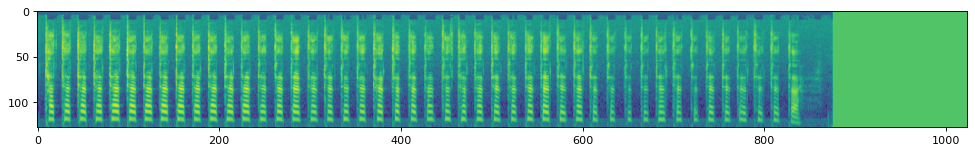

In [8]:
from matplotlib import pyplot as plt
plt.figure(num=1, figsize=(15, 15), dpi=80)
plt.imshow(spectogram.transpose(1,0).flip(0))
plt.show()

As you can see, it gets padded to ~10 seconds, or 1024 timesteps. 

___
Next is the main class for the SSAST. This is a convoluted script since it covers pretraining and fine tuning, many tasks, etc. It would for sure have to be split into separate things if we are to trace it.

In [9]:
# modified from this file

# -*- coding: utf-8 -*-
# @Time    : 7/16/21 3:12 AM
# @Author  : Yuan Gong
# @Affiliation  : Massachusetts Institute of Technology
# @Email   : yuangong@mit.edu
# @File    : ast_models.py
# the unified ast models for all pretraining/fine-tuning tasks.

import torch.nn as nn
import torch
import sys
#sys.path.append("/data/sls/scratch/yuangong/aed-trans/src/models/")
#sys.path.append("/data/sls/scratch/yuangong/aed-trans/src/")
from timm.models.layers import trunc_normal_
import timm
import numpy as np
from timm.models.layers import to_2tuple
from random import randrange
from matplotlib import pyplot as plt
import random

# override the timm package to relax the input shape constraint.
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

def get_sinusoid_encoding(n_position, d_hid):
    ''' Sinusoid position encoding table '''

    def get_position_angle_vec(position):
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table).unsqueeze(0)

class ASTModel(nn.Module):
    def __init__(self, label_dim=527,
                 fshape=128, tshape=2, fstride=128, tstride=2,
                 input_fdim=128, input_tdim=1024, model_size='base',
                 pretrain_stage=True, load_pretrained_mdl_path=None):

        super(ASTModel, self).__init__()
        assert timm.__version__ == '0.4.5', 'Please use timm == 0.4.5, the code might not be compatible with newer versions.'

        # override timm input shape restriction
        timm.models.vision_transformer.PatchEmbed = PatchEmbed

        # pretrain the AST models
        if pretrain_stage == True:
            if load_pretrained_mdl_path != None:
                raise ValueError('Setting load_pretrained_mdl_path at pretraining stage is useless, pretraining is always from scratch, please change it to None.')
            if fstride != fshape or tstride != tshape:
                raise ValueError('fstride != fshape or tstride != tshape, they must be same at the pretraining stage, patch split overlapping is not supported.')

            # if AudioSet pretraining is not used (but ImageNet pretraining may still apply)
            if model_size == 'tiny':
                self.v = timm.create_model('vit_deit_tiny_distilled_patch16_224', pretrained=False)
                self.heads, self.depth = 3, 12
                self.cls_token_num = 2
            elif model_size == 'small':
                self.v = timm.create_model('vit_deit_small_distilled_patch16_224', pretrained=False)
                self.heads, self.depth = 6, 12
                self.cls_token_num = 2
            elif model_size == 'base':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=False)
                self.heads, self.depth = 12, 12
                self.cls_token_num = 2
            elif model_size == 'base_nokd':
                self.v = timm.create_model('vit_deit_base_patch16_384', pretrained=False)
                self.heads, self.depth = 12, 12
                self.cls_token_num = 1
            else:
                raise Exception('Model size must be one of tiny, small, base, base_nokd')

            self.original_num_patches = self.v.patch_embed.num_patches
            self.oringal_hw = int(self.original_num_patches ** 0.5)
            self.original_embedding_dim = self.v.pos_embed.shape[2]

            # SSL Pretraining Code
            self.softmax = nn.Softmax(dim=-1)
            self.lsoftmax = nn.LogSoftmax(dim=-1)
            self.fshape, self.tshape = fshape, tshape
            self.fstride, self.tstride = fstride, tstride
            self.input_fdim, self.input_tdim = input_fdim, input_tdim
            # this is a trick to make state_dict to track pretraining input_fdim and input_tdim and save them by using torch.save
            self.p_input_fdim, self.p_input_tdim = nn.Parameter(torch.tensor(input_fdim), requires_grad=False), nn.Parameter(torch.tensor(input_tdim), requires_grad=False)

            # masked patch classification (discriminative objective) layer
            # we use two layers for pretext task, but using a single layer has similar performance.
            # we map the output of transformer (768-dim for base models) to 256-dim patch input space, and then dot product with flattened patch input (also 256-dim) to calculate loss.
            # alternatively, you can map the output of transformer to 768-dim patch embedding space, and dot product with patch embedding. Performance-wise they are similar, but map to 256 space is more efficient.
            self.cpredlayer = nn.Sequential(nn.Linear(self.original_embedding_dim, self.original_embedding_dim), nn.ReLU(), nn.Linear(self.original_embedding_dim, 256))
            # masked patch reconstruction (generative objective) layer
            self.gpredlayer = nn.Sequential(nn.Linear(self.original_embedding_dim, self.original_embedding_dim), nn.ReLU(), nn.Linear(self.original_embedding_dim, 256))
            self.unfold = torch.nn.Unfold(kernel_size=(fshape, tshape), stride=(fstride, tstride))

            # we use learnable mask embedding (follow the BEIT paper), but using a fixed mask embedding (e.g., 0) leads to same performance.
            self.mask_embed = nn.Parameter(torch.zeros([1, 1, self.original_embedding_dim]))
            self.mask_embed = torch.nn.init.xavier_normal_(self.mask_embed)

            # get the intermediate shape
            self.p_f_dim, self.p_t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim, fshape, tshape)
            num_patches = self.p_f_dim * self.p_t_dim
            self.num_patches = num_patches
            self.v.patch_embed.num_patches = num_patches
            print('pretraining patch split stride: frequency={:d}, time={:d}'.format(fstride, tstride))
            print('pretraining patch shape: frequency={:d}, time={:d}'.format(fshape, tshape))
            print('pretraining patch array dimension: frequency={:d}, time={:d}'.format(self.p_f_dim, self.p_t_dim))
            print('pretraining number of patches={:d}'.format(num_patches))

            # the linear patch projection layer, use 1 channel for spectrogram rather than the original 3 channels for RGB images.
            new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(fshape, tshape), stride=(fstride, tstride))
            self.v.patch_embed.proj = new_proj

            # use trainable positional embedding
            new_pos_embed = nn.Parameter(torch.zeros(1, self.v.patch_embed.num_patches + self.cls_token_num, self.original_embedding_dim))
            self.v.pos_embed = new_pos_embed
            trunc_normal_(self.v.pos_embed, std=.02)

        # use a pretrained models for finetuning
        elif pretrain_stage == False:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            if load_pretrained_mdl_path == None:
                raise ValueError('Please set load_pretrained_mdl_path to load a pretrained models.')
            sd = torch.load(load_pretrained_mdl_path, map_location=device)
            # get the fshape and tshape, input_fdim and input_tdim in the pretraining stage
            try:
                p_fshape, p_tshape = sd['module.module.v.patch_embed.proj.weight'].shape[2], sd['module.module.v.patch_embed.proj.weight'].shape[3]
                p_input_fdim, p_input_tdim = sd['module.module.p_input_fdim'].item(), sd['module.module.p_input_tdim'].item()
            except:
                raise  ValueError('The model loaded is not from a torch.nn.Dataparallel object. Wrap it with torch.nn.Dataparallel and try again.')

            print('now load a SSL pretrained models from ' + load_pretrained_mdl_path)
            # during pretraining, fstride=fshape and tstride=tshape because no patch overlapping is used
            # here, input_fdim and input_tdim should be that used in pretraining, not that in the fine-tuning.
            # we need to know input_fdim and input_tdim to do positional embedding cut/interpolation.
            # generally it should be better to use same input_fdim during pretraining and finetuning, but input_tdim can be safely different
            audio_model = ASTModel(fstride=p_fshape, tstride=p_tshape, fshape=p_fshape, tshape=p_tshape,
                                   input_fdim=p_input_fdim, input_tdim=p_input_tdim, pretrain_stage=True, model_size=model_size)
            audio_model = torch.nn.DataParallel(audio_model)
            audio_model.load_state_dict(sd, strict=False)

            self.v = audio_model.module.v
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.cls_token_num = audio_model.module.cls_token_num
            
            
            self.unfold = torch.nn.Unfold(kernel_size=(fshape, tshape), stride=(fstride, tstride))
            

            # mlp head for fine-tuning
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim),
                                          nn.Linear(self.original_embedding_dim, label_dim))

            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim, fshape, tshape)
            # patch array dimension during pretraining
            p_f_dim, p_t_dim = audio_model.module.p_f_dim, audio_model.module.p_t_dim
            num_patches = f_dim * t_dim
            p_num_patches = p_f_dim * p_t_dim
            self.v.patch_embed.num_patches = num_patches
            print('fine-tuning patch split stride: frequncey={:d}, time={:d}'.format(fstride, tstride))
            print('fine-tuning number of patches={:d}'.format(num_patches))

            # patch shape should be same for pretraining and fine-tuning
            if fshape != p_fshape or tshape != p_tshape:
                raise ValueError('The patch shape of pretraining and fine-tuning is not consistant, pretraining: f={:d}, t={:d}, finetuning: f={:d}, t={:d}'.format(p_fshape, p_tshape, fshape, tshape))

            # patch split stride generally should be different for pretraining and fine-tuning, as patch split overlapping is only used in finetuning
            # during pretraining, p_fshape = p_fstride and p_tshape = p_tstride
            if fstride != p_fshape or tstride != p_tshape:
                # initialize a new patch embedding layer with desired new stride.
                new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(fshape, tshape), stride=(fstride, tstride))
                # but the weights of patch embedding layer is still got from the pretrained models
                new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
                new_proj.bias = self.v.patch_embed.proj.bias
                self.v.patch_embed.proj = new_proj

            new_pos_embed = self.v.pos_embed[:, self.cls_token_num:, :].detach().reshape(1, p_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, p_f_dim, p_t_dim)
            # cut or interpolate the positional embedding
            if t_dim < p_t_dim:
                new_pos_embed = new_pos_embed[:, :, :, int(p_t_dim/2) - int(t_dim / 2): int(p_t_dim/2) - int(t_dim / 2) + t_dim]
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(8, t_dim), mode='bilinear')
            if f_dim < p_f_dim:
                new_pos_embed = new_pos_embed[:, :, int(p_f_dim/2) - int(f_dim / 2): int(p_f_dim/2) - int(f_dim / 2) + t_dim, :]
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')

            new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1, 2)
            self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :self.cls_token_num, :].detach(), new_pos_embed], dim=1))

    # get the shape of intermediate representation.
    def get_shape(self, fstride, tstride, input_fdim, input_tdim, fshape, tshape):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(fshape, tshape), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    # generate mask for 16*16 patch
    def gen_maskid_patch(self, sequence_len=512, mask_size=100, cluster=3):
        mask_id = []

        # randomize clutering factor in [3,6)
        cur_clus = randrange(cluster) + 3

        while len(list(set(mask_id))) <= mask_size:
            start_id = randrange(sequence_len)

            # this improves the efficiency, but might change the pretrained model
            # while start_id in mask_id:
            #     start_id = randrange(sequence_len)

            cur_mask = []
            for i in range(0, cur_clus):
                for j in range(0, cur_clus):
                    mask_cand = start_id + self.p_t_dim * i + j
                    if mask_cand > 0 and mask_cand < sequence_len:
                        cur_mask.append(mask_cand)
            mask_id = mask_id + cur_mask
        mask_id = list(set(mask_id))[:mask_size]
        return torch.tensor(mask_id)

    # using cluster for frame masking hurts the performance, so just use the naive random sampling
    def gen_maskid_frame(self, sequence_len=512, mask_size=100):
        mask_id = random.sample(range(0, sequence_len), mask_size)
        return torch.tensor(mask_id)

    def finetuningavgtok(self, x):
        B = x.shape[0]
        x = self.v.patch_embed(x)
        if self.cls_token_num == 2:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            dist_token = self.v.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        else:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)

        for blk_id, blk in enumerate(self.v.blocks):
            x = blk(x)
        x = self.v.norm(x)

        # average output of all tokens except cls token(s)
        x = torch.mean(x[:, self.cls_token_num:, :], dim=1)
        x = self.mlp_head(x)
        return x
    
    def finetuningavgtok_embed(self, x):
        B = x.shape[0]
        x = self.v.patch_embed(x)
        if self.cls_token_num == 2:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            dist_token = self.v.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        else:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)

        for blk_id, blk in enumerate(self.v.blocks):
            x = blk(x)
        x = self.v.norm(x)

        # average output of all tokens except cls token(s)
        x = torch.mean(x[:, self.cls_token_num:, :], dim=1)
        #x = self.mlp_head(x)
        return x

    def finetuningcls(self, x):
        B = x.shape[0]
        x = self.v.patch_embed(x)
        if self.cls_token_num == 2:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            dist_token = self.v.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        else:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)

        for blk_id, blk in enumerate(self.v.blocks):
            x = blk(x)
        x = self.v.norm(x)

        # if models has two cls tokens (DEIT), average as the clip-level representation
        if self.cls_token_num == 2:
            x = (x[:, 0] + x[:, 1]) / 2
        else:
            x = x[:, 0]
        x = self.mlp_head(x)
        return x

    # masked patch pretraining with discriminative objective
    def mpc(self, x, mask_patch, cluster, show_mask=False):
        input = self.unfold(x).transpose(1, 2)
        B = x.shape[0]
        # x in shape (batch_size, sequence_len, embedding dim)
        x = self.v.patch_embed(x)

        # encode the patch
        # size 12(batch_size) * 100(#mask_patch) * 768(hidden_dim), prepare to save the true values of masked samples
        encode_samples = torch.empty((B, mask_patch, 256), device=x.device, requires_grad=False).float()
        # size 12(batch_size) * 100(#mask_patch), index of masked patches
        mask_index = torch.empty((B, mask_patch), device=x.device, requires_grad=False).long()
        # size 12(batch_size) * 512(sequence_len) * 768(hidden_dim)
        mask_dense = torch.ones([x.shape[0], x.shape[1], x.shape[2]], device=x.device)

        # for each audio clip in the batch
        for i in range(B):
            # randomly generate #mask_patch mask indexes without duplicate
            if cluster == True:
                # use this if you are masking e.g. 16*16 patches
                mask_index[i] = self.gen_maskid_patch(self.num_patches, mask_patch)
            else:
                # use this if you are masking frame, i.e., 128*2 patches
                mask_index[i] = self.gen_maskid_frame(self.num_patches, mask_patch)
            # copy the masked embeddings, note gradients are stopped in this path
            encode_samples[i] = input[i, mask_index[i], :].clone().detach()
            # mask the encode samples with 0
            mask_dense[i, mask_index[i], :] = 0

        # follow BEIT paper, mask with learnable masking embedding, but no performance diff observed compared with masking with 0s.
        mask_tokens = self.mask_embed.expand(B, x.shape[1], -1)

        # mask the patch
        x = x * mask_dense + (1-mask_dense) * mask_tokens

        # pass through the Transformer layers
        cls_tokens = self.v.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)

        # prediction of the masked patch
        pred = torch.empty((B, mask_patch, 256), device=x.device).float()  # e.g. size 12*100*768
        for i in range(B):
            #  +2 for indexes because skipping the cls and dis token
            # we map the output of transformer (768-dim for base models) to 256-dim patch input space, and then dot product with flattened patch input (also 256-dim) to calculate loss.
            # alternatively, you can map the output of transformer to 768-dim patch embedding space, and dot product with patch embedding. Performance-wise they are similar, but map to 256 space is more efficient.
            pred[i] = self.cpredlayer(x[i, mask_index[i] + self.cls_token_num, :])

        # calculate the NCE loss
        nce = torch.tensor(0.0).to(x.device)
        correct = torch.tensor(0.0).to(x.device)
        for i in np.arange(0, B):
            # negative samples are from the same batch
            # equation (1) of the ssast paper
            total = torch.mm(encode_samples[i], torch.transpose(pred[i], 0, 1))  # e.g. size 100*100
            correct += torch.sum(torch.eq(torch.argmax(self.softmax(total), dim=0), torch.arange(0, mask_patch, device=x.device)))  # correct is a tensor
            nce += torch.sum(torch.diag(self.lsoftmax(total)))  # nce is a tensor
        acc = 1. * correct / (B * mask_patch)
        nce = nce / (-1. * B * mask_patch)

        # visualize the masked area, for probing test only, set show_mask = False for any training/inference.
        if show_mask == False:
            return acc, nce
        else:
            if B > 1:
                raise Exception('Currently only support single spectrogram probing test.')
            
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            self.mask_correct = torch.nn.Parameter(torch.arange(0, mask_patch), requires_grad=False).to(device)

            pred = input.clone().to(device)  # [B, 512, 256]
            masked = input.clone().to(device) 
            
            #print(pred.device)
            #print(masked.device)

            for i in range(B):
                result = [float(t) * 99 for t in torch.eq(torch.argmax(self.softmax(total), dim=0), self.mask_correct)]
                #print(result)
                pred[i, mask_index[i], :] = torch.tensor(result, device=device).reshape(mask_patch, 1).expand(mask_patch, 256)
                masked[i, mask_index[i], :] = 99.0

            # print(total)
            # print(self.softmax(total))
            # print(torch.argmax(self.softmax(total), dim=0))
            # print(self.mask_correct)
            # print(torch.eq(torch.argmax(self.softmax(total), dim=0), self.mask_correct))
            # print([float(t)*99 for t in torch.eq(torch.argmax(self.softmax(total), dim=0), self.mask_correct)])

            fold = torch.nn.Fold(output_size=([self.input_fdim, self.input_tdim]), kernel_size=(self.fshape, self.tshape), stride=(self.fstride, self.tstride))
            pred = fold(pred.transpose(1, 2))
            masked = fold(masked.transpose(1, 2))

            return pred, masked

    # # masked patch pretraining with generative objective
    def mpg(self, input, mask_patch, cluster):
        B = input.shape[0]
        x = self.v.patch_embed(input)
        input = self.unfold(input).transpose(1, 2)

        # size 12(batch_size) * 100(#mask_patch), index of masked patches
        mask_index = torch.empty((B, mask_patch), device=x.device, requires_grad=False).long()
        # size 12(batch_size) * 512(sequence_len) * 768(hidden_dim)
        mask_dense = torch.ones([x.shape[0], x.shape[1], x.shape[2]], device=x.device)
        for i in range(B):
            # randomly generate #mask_patch mask indexes without duplicate
            if cluster == True:
                # use this if you are masking e.g. 16*16 patches
                mask_index[i] = self.gen_maskid_patch(self.num_patches, mask_patch)
            else:
                # use this if you are masking frame, i.e., 128*2 patches
                mask_index[i] = self.gen_maskid_frame(self.num_patches, mask_patch)
            mask_dense[i, mask_index[i], :] = 0

        mask_tokens = self.mask_embed.expand(B, x.shape[1], -1)

        # follow BEIT paper, mask with learnable masking embedding, but no performance diff observed compared with masking with 0s.
        x = x * mask_dense + (1-mask_dense) * mask_tokens

        # go through the Transformer layers
        cls_tokens = self.v.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)

        pred = torch.empty((B, mask_patch, self.fshape * self.tshape), device=x.device).float()  # e.g. size 12*100*256
        target = torch.empty((B, mask_patch, self.fshape * self.tshape), device=x.device).float() # e.g. size 12*100*256

        for i in range(B):
            #  +2 for indexes because cls and dis token
            pred[i] = self.gpredlayer(x[i, mask_index[i] + self.cls_token_num, :])
            target[i] = input[i, mask_index[i], :]

        # calculate the MSE loss
        mse = torch.mean((pred - target) ** 2)

        return mse

    def forward(self, x, task, cluster=True, mask_patch=400):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        # finetuning (ft), use the mean of all token (patch) output as clip-level representation.
        # this is default for SSAST fine-tuning as during pretraining, supervision signal is given to each token, not the [cls] token
        if task == 'ft_avgtok':
            return self.finetuningavgtok(x)
        # alternatively, use the [cls] token output as clip-level representation.
        elif task == 'ft_cls':
            return self.finetuningcls(x)
        # pretraining, masked patch classification (discriminative objective)
        elif task == 'pretrain_mpc':
            return self.mpc(x, mask_patch=mask_patch, cluster=cluster)
        # pretraining, masked patch reconstruction (generative objective)
        elif task == 'pretrain_mpg':
            return self.mpg(x, mask_patch=mask_patch, cluster=cluster)
        elif task == 'visualize_mask':
            return self.mpc(x, mask_patch=mask_patch, cluster=cluster, show_mask=True)
        elif task == 'ft_avgtok_embed':
            return self.finetuningavgtok_embed(x)
        else:
            raise Exception('Task unrecognized.')



For the most part it is the same as in the repo, but I added the ft_avtok_embed one. Regardless, it needs to be refactored to work with attention visualization etc


Perhaps we can use their pre-pretrained one to see how well it predicts patches in our speech and then maybe even get embeddings there as an absolute bare minimum baseline.

In [10]:
input_tdim = 1024

ast_mdl = ASTModel(fshape=128, tshape=2, fstride=128, tstride=2,input_fdim=128, input_tdim=input_tdim, model_size='base',pretrain_stage=True)

pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=512
pretraining number of patches=512


In [11]:
# replace the dictionary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_pretrained_mdl_path='/home/jupyter/ast/ssast/pretrained_model/SSAST-Base-Frame-400.pth'
sd = torch.load(load_pretrained_mdl_path, map_location=device)
ast_mdl = torch.nn.DataParallel(ast_mdl)
ast_mdl.load_state_dict(sd, strict=False)


<All keys matched successfully>

In [12]:
ast_mdl.cuda()

DataParallel(
  (module): ASTModel(
    (v): DistilledVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 768, kernel_size=(128, 2), stride=(128, 2))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU()
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): Dropout(p=0.0, inplace=False)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
spectogram, label, filename = test_loader.dataset[1]
tst_case=spectogram.to(device)
tst_case_=tst_case[None,:]

In [14]:
acc, nce = ast_mdl(tst_case_, task='pretrain_mpc', mask_patch=100)
print(acc), print(nce)

tensor(0.0700, device='cuda:0')
tensor(12.1484, device='cuda:0', grad_fn=<DivBackward0>)


(None, None)

In [15]:
pred, masked = ast_mdl(tst_case_, task='visualize_mask', mask_patch=100)

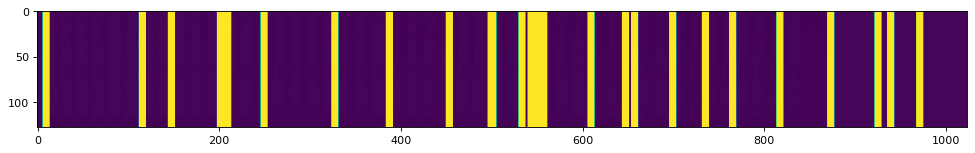

In [16]:
plt.figure(num=1, figsize=(15, 25), dpi=80)
plt.imshow(masked.cpu()[0,0,:,:])
plt.show()

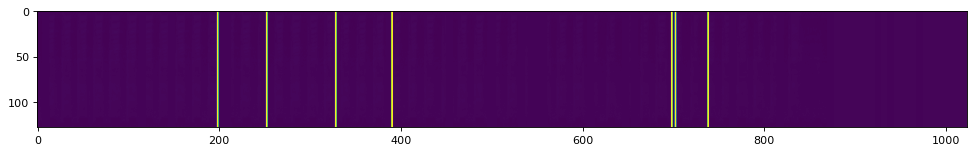

In [17]:
plt.figure(num=1, figsize=(15, 25), dpi=80)
plt.imshow(pred.cpu().transpose(1, 0)[0,0,:,:])
plt.show()

Not sure if that's working as intended, tbh, but if so it *sucks*. We may have to pretrain mode on our data!

In [18]:

import sys
import os
import datetime
# sys.path.append(os.path.dirname(os.path.dirname(sys.path[0])))
sys.path.append('/home/jupyter/ast/ssast/src/')
from utilities import * # just following his 
import time
import torch
import numpy as np
import pickle

def trainmask(audio_model, train_loader, test_loader, args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('Now running on : ' + str(device))

    # initialize all of the statistics we want to keep track of
    batch_time = AverageMeter()
    per_sample_time = AverageMeter()
    data_time = AverageMeter()
    per_sample_data_time = AverageMeter()
    loss_meter = AverageMeter()
    per_sample_dnn_time = AverageMeter()
    train_acc_meter = AverageMeter()
    train_nce_meter = AverageMeter()
    progress = []
    best_epoch, best_acc = 0, -np.inf
    global_step, epoch = 0, 0
    start_time = time.time()
    exp_dir = args.exp_dir

    def _save_progress():
        progress.append([epoch, global_step, best_epoch, time.time() - start_time])
        with open("%s/progress.pkl" % exp_dir, "wb") as f:
            pickle.dump(progress, f)

    if not isinstance(audio_model, nn.DataParallel):
        audio_model = nn.DataParallel(audio_model)

    audio_model = audio_model.to(device)
    # Set up the optimizer
    audio_trainables = [p for p in audio_model.parameters() if p.requires_grad]
    print('Total parameter number is : {:.9f} million'.format(sum(p.numel() for p in audio_model.parameters()) / 1e6))
    print('Total trainable parameter number is : {:.9f} million'.format(sum(p.numel() for p in audio_trainables) / 1e6))
    trainables = audio_trainables
    optimizer = torch.optim.Adam(trainables, args.lr, weight_decay=5e-7, betas=(0.95, 0.999))

    # LR scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=args.lr_patience, verbose=True)
    epoch += 1

    print("current #steps=%s, #epochs=%s" % (global_step, epoch))
    print("start training...")

    result = []
    audio_model.train()

    # training until break
    while epoch < args.n_epochs + 1:
        begin_time = time.time()
        end_time = time.time()
        audio_model.train()
        print(datetime.datetime.now())

        # save from-scratch models before the first epoch
        torch.save(audio_model.state_dict(), "%s/models/audio_model.%d.pth" % (exp_dir, global_step+1))

        for i, (audio_input, _, _) in enumerate(train_loader):
            # measure data loading time
            B = audio_input.size(0)
            audio_input = audio_input.to(device, non_blocking=True)

            data_time.update(time.time() - end_time)
            per_sample_data_time.update((time.time() - end_time) / audio_input.shape[0])
            dnn_start_time = time.time()

            # first several steps for warm-up
            if global_step <= 1000 and global_step % 50 == 0:
                warm_lr = (global_step / 1000) * args.lr
                for param_group in optimizer.param_groups:
                    param_group['lr'] = warm_lr
                print('warm-up learning rate is {:f}'.format(optimizer.param_groups[0]['lr']))

            # use cluster masking only when masking patches, not frames
            cluster = (args.num_mel_bins != args.fshape)
            # if pretrain with discriminative objective
            if args.task == 'pretrain_mpc':
                acc, loss = audio_model(audio_input, args.task, mask_patch=args.mask_patch, cluster=cluster)
                # this is for multi-gpu support, in our code, loss is calculated in the model
                # pytorch concatenates the output of each gpu, we thus get mean of the losses of each gpu
                acc, loss = acc.mean(), loss.mean()
            # if pretrain with generative objective
            elif args.task == 'pretrain_mpg':
                loss = audio_model(audio_input, args.task, mask_patch=args.mask_patch, cluster=cluster)
                loss = loss.mean()
                # dirty code to make the code report mse loss for generative objective
                acc = loss
            # if pretrain with joint discriminative and generative objective
            elif args.task == 'pretrain_joint':
                acc, loss1 = audio_model(audio_input, 'pretrain_mpc', mask_patch=args.mask_patch, cluster=cluster)
                acc, loss1 = acc.mean(), loss1.mean()
                loss2 = audio_model(audio_input, 'pretrain_mpg', mask_patch=args.mask_patch, cluster=cluster)
                loss2 = loss2.mean()
                loss = loss1 + 10 * loss2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # record loss
            train_acc_meter.update(acc.detach().cpu().item())
            train_nce_meter.update(loss.detach().cpu().item())
            loss_meter.update(loss.item(), B)
            batch_time.update(time.time() - end_time)
            per_sample_time.update((time.time() - end_time)/audio_input.shape[0])
            per_sample_dnn_time.update((time.time() - dnn_start_time)/audio_input.shape[0])

            print_step = global_step % args.n_print_steps == 0
            early_print_step = epoch == 0 and global_step % (args.n_print_steps/10) == 0
            print_step = print_step or early_print_step

            if print_step and global_step != 0:
                print('Epoch: [{0}][{1}/{2}]\t'
                  'Per Sample Total Time {per_sample_time.avg:.5f}\t'
                  'Per Sample Data Time {per_sample_data_time.avg:.5f}\t'
                  'Per Sample DNN Time {per_sample_dnn_time.avg:.5f}\t'
                  'Train Loss {loss_meter.val:.4f}\t'.format(
                   epoch, i, len(train_loader), per_sample_time=per_sample_time, per_sample_data_time=per_sample_data_time,
                      per_sample_dnn_time=per_sample_dnn_time, loss_meter=loss_meter), flush=True)
                if np.isnan(loss_meter.avg):
                    print("training diverged...")
                    return

            end_time = time.time()
            global_step += 1

            # pretraining data is usually very large, save model every epoch is too sparse.
            # save the model every args.epoch_iter steps.
            epoch_iteration = args.epoch_iter
            if global_step % epoch_iteration == 0:
                print('---------------- step '+ str(global_step) +' evaluation ----------------')
                equ_epoch = int(global_step/epoch_iteration) + 1
                acc_eval, nce_eval = validatemask(audio_model, test_loader, args, equ_epoch)

                print("masked acc train: {:.6f}".format(acc))
                print("nce loss train: {:.6f}".format(loss))
                print("masked acc eval: {:.6f}".format(acc_eval))
                print("nce loss eval: {:.6f}".format(nce_eval))
                result.append([train_acc_meter.avg, train_nce_meter.avg, acc_eval, nce_eval, optimizer.param_groups[0]['lr']])
                np.savetxt(exp_dir + '/result.csv', result, delimiter=',')

                if acc > best_acc:
                    best_acc = acc
                    torch.save(audio_model.state_dict(), "%s/models/best_audio_model.pth" % (exp_dir))

                torch.save(audio_model.state_dict(), "%s/models/audio_model.%d.pth" % (exp_dir, equ_epoch))
                if len(train_loader.dataset) > 2e5:
                    torch.save(optimizer.state_dict(), "%s/models/optim_state.pth" % (exp_dir))

                # if the task is generation, stop after eval mse loss stop improve
                if args.task == 'pretrain_mpg':
                    # acc_eval is in fact the mse loss, it is dirty code
                    scheduler.step(-acc_eval)
                else:
                    scheduler.step(acc_eval)

                print('# {:d}, step {:d}-{:d}, lr: {:e}'.format(equ_epoch, global_step-epoch_iteration, global_step, optimizer.param_groups[0]['lr']))

                _save_progress()

                finish_time = time.time()
                print('# {:d}, step {:d}-{:d}, training time: {:.3f}'.format(equ_epoch, global_step-epoch_iteration, global_step, finish_time-begin_time))
                begin_time = time.time()

                train_acc_meter.reset()
                train_nce_meter.reset()
                batch_time.reset()
                per_sample_time.reset()
                data_time.reset()
                per_sample_data_time.reset()
                loss_meter.reset()
                per_sample_dnn_time.reset()

                # change the models back to train mode
                audio_model.train()
                print('---------------- evaluation finished ----------------')
        epoch += 1

def validatemask(audio_model, val_loader, args, epoch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if not isinstance(audio_model, nn.DataParallel):
        audio_model = nn.DataParallel(audio_model)
    audio_model = audio_model.to(device)
    # switch to evaluate mode
    audio_model.eval()

    A_acc = []
    A_nce = []
    with torch.no_grad():
        for i, (audio_input, _, _) in enumerate(val_loader):
            audio_input = audio_input.to(device)

            # use cluster masking only when masking patches, not frames
            cluster = (args.num_mel_bins != args.fshape)
            # always use mask_patch=400 for evaluation, even the training mask patch number differs.
            if args.task == 'pretrain_mpc':
                acc, nce = audio_model(audio_input, args.task, mask_patch=400, cluster=cluster)
                A_acc.append(torch.mean(acc).cpu())
                A_nce.append(torch.mean(nce).cpu())
            elif args.task == 'pretrain_mpg':
                mse = audio_model(audio_input, args.task, mask_patch=400, cluster=cluster)
                # this is dirty code to track mse loss, A_acc and A_nce now track mse, not the name suggests
                A_acc.append(torch.mean(mse).cpu())
                A_nce.append(torch.mean(mse).cpu())
            elif args.task == 'pretrain_joint':
                acc, _ = audio_model(audio_input, 'pretrain_mpc', mask_patch=400, cluster=cluster)
                mse = audio_model(audio_input, 'pretrain_mpg', mask_patch=400, cluster=cluster)

                A_acc.append(torch.mean(acc).cpu())
                # A_nce then tracks the mse loss
                A_nce.append(torch.mean(mse).cpu())

        acc = np.mean(A_acc)
        nce = np.mean(A_nce)

    return acc, nce

In [19]:
# create fake args list
import argparse
import ast

parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument("--data-train", type=str, default=None, help="training data json")
parser.add_argument("--data-val", type=str, default=None, help="validation data json")
parser.add_argument("--data-eval", type=str, default=None, help="evaluation data json")
parser.add_argument("--label-csv", type=str, default='', help="csv with class labels")
parser.add_argument("--n_class", type=int, default=1, help="number of classes")

parser.add_argument("--dataset", type=str, help="the dataset used for training")
parser.add_argument("--dataset_mean", type=float, help="the dataset mean, used for input normalization")
parser.add_argument("--dataset_std", type=float, help="the dataset std, used for input normalization")
parser.add_argument("--target_length", type=int, help="the input length in frames")
parser.add_argument("--num_mel_bins", type=int, default=128, help="number of input mel bins")

parser.add_argument("--exp-dir", type=str, default="", help="directory to dump experiments")
parser.add_argument('--lr', '--learning-rate', default=0.001, type=float, metavar='LR', help='initial learning rate')
parser.add_argument('--warmup', help='if use warmup learning rate scheduler', type=ast.literal_eval, default='True')
parser.add_argument("--optim", type=str, default="adam", help="training optimizer", choices=["sgd", "adam"])
parser.add_argument('-b', '--batch-size', default=24, type=int, metavar='N', help='mini-batch size')
parser.add_argument('-w', '--num-workers', default=16, type=int, metavar='NW', help='# of workers for dataloading (default: 32)')
parser.add_argument("--n-epochs", type=int, default=1, help="number of maximum training epochs")
# only used in pretraining stage or from-scratch fine-tuning experiments
parser.add_argument("--lr_patience", type=int, default=1, help="how many epoch to wait to reduce lr if mAP doesn't improve")
parser.add_argument('--adaptschedule', help='if use adaptive scheduler ', type=ast.literal_eval, default='False')

parser.add_argument("--n-print-steps", type=int, default=100, help="number of steps to print statistics")
parser.add_argument('--save_model', help='save the models or not', type=ast.literal_eval)

parser.add_argument('--freqm', help='frequency mask max length', type=int, default=0)
parser.add_argument('--timem', help='time mask max length', type=int, default=0)
parser.add_argument("--mixup", type=float, default=0, help="how many (0-1) samples need to be mixup during training")
parser.add_argument("--bal", type=str, default=None, help="use balanced sampling or not")
# the stride used in patch spliting, e.g., for patch size 16*16, a stride of 16 means no overlapping, a stride of 10 means overlap of 6.
# during self-supervised pretraining stage, no patch split overlapping is used (to aviod shortcuts), i.e., fstride=fshape and tstride=tshape
# during fine-tuning, using patch split overlapping (i.e., smaller {f,t}stride than {f,t}shape) improves the performance.
# it is OK to use different {f,t} stride in pretraining and finetuning stages (though fstride is better to keep the same)
# but {f,t}stride in pretraining and finetuning stages must be consistent.
parser.add_argument("--fstride", type=int, help="soft split freq stride, overlap=patch_size-stride")
parser.add_argument("--tstride", type=int, help="soft split time stride, overlap=patch_size-stride")
parser.add_argument("--fshape", type=int, help="shape of patch on the frequency dimension")
parser.add_argument("--tshape", type=int, help="shape of patch on the time dimension")
parser.add_argument('--model_size', help='the size of AST models', type=str, default='base384')

parser.add_argument("--task", type=str, default='ft_cls', help="pretraining or fine-tuning task", choices=["ft_avgtok", "ft_cls", "pretrain_mpc", "pretrain_mpg", "pretrain_joint"])

# pretraining augments
parser.add_argument('--pretrain_stage', help='True for self-supervised pretraining stage, False for fine-tuning stage', type=ast.literal_eval, default='False')
parser.add_argument('--mask_patch', help='how many patches to mask (used only for ssl pretraining)', type=int, default=400)
parser.add_argument("--cluster_factor", type=int, default=3, help="mask clutering factor")
parser.add_argument("--epoch_iter", type=int, default=2000, help="for pretraining, how many iterations to verify and save models")

# fine-tuning arguments
parser.add_argument("--pretrained_mdl_path", type=str, default=None, help="the ssl pretrained models path")
parser.add_argument("--head_lr", type=int, default=1, help="the factor of mlp-head_lr/lr, used in some fine-tuning experiments only")
parser.add_argument("--noise", help='if augment noise in finetuning', type=ast.literal_eval)
parser.add_argument("--metrics", type=str, default="mAP", help="the main evaluation metrics in finetuning", choices=["mAP", "acc"])
parser.add_argument("--lrscheduler_start", default=10, type=int, help="when to start decay in finetuning")
parser.add_argument("--lrscheduler_step", default=5, type=int, help="the number of step to decrease the learning rate in finetuning")
parser.add_argument("--lrscheduler_decay", default=0.5, type=float, help="the learning rate decay ratio in finetuning")
parser.add_argument("--wa", help='if do weight averaging in finetuning', type=ast.literal_eval)
parser.add_argument("--wa_start", type=int, default=16, help="which epoch to start weight averaging in finetuning")
parser.add_argument("--wa_end", type=int, default=30, help="which epoch to end weight averaging in finetuning")
parser.add_argument("--loss", type=str, default="BCE", help="the loss function for finetuning, depend on the task", choices=["BCE", "CE"])


task='pretrain_joint' # standard for pretraining
mask_patch=400

# audioset and librispeech
dataset='legacy_smr'
tr_data='/home/jupyter/ast/mayo_legacy_all.json'
te_data='/home/jupyter/ast/mayo_legacy_all.json'
#dataset_mean=-2.1636887 # I show how to calculate these below
#dataset_std=3.881401 # I show how to calculate these below
dataset_mean=-4.2677393
dataset_std=4.5689974
target_length=1024
num_mel_bins=128

label_csv='/home/jupyter/ast/ssast/src/prep_data/dummy_labels.csv'

model_size='base'
# no patch split overlap
fshape=128
tshape=2
fstride=fshape
tstride=tshape
# no class balancing as it implicitly uses label information
bal='none'
batch_size=20
lr=0.0001
# learning rate decreases if the pretext task performance does not improve on the validation set
lr_patience=2
epoch=8
# no spectrogram masking
freqm=0
timem=0
# no mixup training
mixup=0

args = parser.parse_args(['--exp-dir', '/home/jupyter/ast/exp_smr', '--loss', "BCE", '--dataset', dataset, 
                         '--data-train', tr_data, '--data-val', te_data, '--label-csv', '/home/jupyter/ast/ssast/src/prep_data/dummy_labels.csv',
                         '--lr', str(lr) ,'--n-epochs', str(epoch), '--save_model', str(True),
                         '--freqm',str(freqm) ,'--timem',str(timem), '--mixup',str(mixup), '--bal', bal,
                         '--tstride' ,str(tstride), '--fstride', str(fstride), '--fshape', str(fshape), '--tshape', str(tshape),
                         '--dataset_mean',str(dataset_mean), '--dataset_std', str(dataset_std), '--target_length', str(target_length), '--num_mel_bins', str(num_mel_bins),
                         '--model_size', str(model_size), '--mask_patch', str(mask_patch), '--n-print-steps', '100',
                         '--task', task, '--lr_patience', str(lr_patience), '--epoch_iter', str(4000)])


In [20]:
print("\nCreating experiment directory: %s" % args.exp_dir)
if os.path.exists("%s/models" % args.exp_dir) == False:
    os.makedirs("%s/models" % args.exp_dir)
with open("%s/args.pkl" % args.exp_dir, "wb") as f:
    pickle.dump(args, f)


Creating experiment directory: /home/jupyter/ast/exp_smr


In [21]:
if 'pretrain' not in args.task:
    print('Now starting fine-tuning for {:d} epochs'.format(args.n_epochs))
    train(ast_mdl, test_loader, val_loader, args)
else:
    print('Now starting self-supervised pretraining for {:d} epochs'.format(args.n_epochs))
    trainmask(ast_mdl, test_loader, val_loader, args)

Now starting self-supervised pretraining for 8 epochs
Now running on : cuda
Total parameter number is : 88.763346000 million
Total trainable parameter number is : 88.763344000 million
current #steps=0, #epochs=1
start training...
2022-06-10 13:07:52.317844
warm-up learning rate is 0.000000
warm-up learning rate is 0.000005
warm-up learning rate is 0.000010
Epoch: [1][100/1046]	Per Sample Total Time 0.02184	Per Sample Data Time 0.00195	Per Sample DNN Time 0.01989	Train Loss 5.7457	
warm-up learning rate is 0.000015
warm-up learning rate is 0.000020
Epoch: [1][200/1046]	Per Sample Total Time 0.02097	Per Sample Data Time 0.00111	Per Sample DNN Time 0.01986	Train Loss 4.8421	
warm-up learning rate is 0.000025
warm-up learning rate is 0.000030
Epoch: [1][300/1046]	Per Sample Total Time 0.02068	Per Sample Data Time 0.00083	Per Sample DNN Time 0.01985	Train Loss 4.9488	
warm-up learning rate is 0.000035
warm-up learning rate is 0.000040
Epoch: [1][400/1046]	Per Sample Total Time 0.02053	Per S

In [22]:
torch.save(ast_mdl.state_dict(), '/home/jupyter/ast/exp_smr/models/all_legacy_their_pretrained_mdl_20220610.pth')

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
spectogram, label, filename = test_loader.dataset[1]
tst_case=spectogram.to(device)
tst_case_=tst_case[None,:]

In [24]:
acc, nce = ast_mdl(tst_case_, task='pretrain_mpc', mask_patch=100)
print(acc), print(nce)

tensor(0.4600, device='cuda:0')
tensor(1.7962, device='cuda:0', grad_fn=<DivBackward0>)


(None, None)

In [25]:
pred, masked = ast_mdl(tst_case_, task='visualize_mask', mask_patch=100)

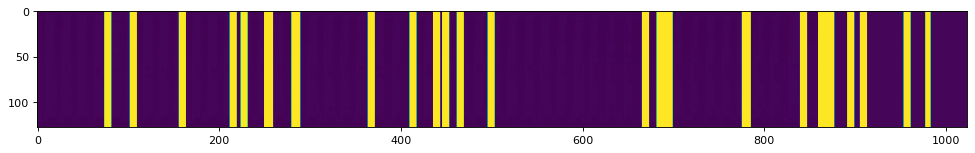

In [26]:
plt.figure(num=1, figsize=(15, 25), dpi=80)
plt.imshow(masked.cpu()[0,0,:,:])
plt.show()

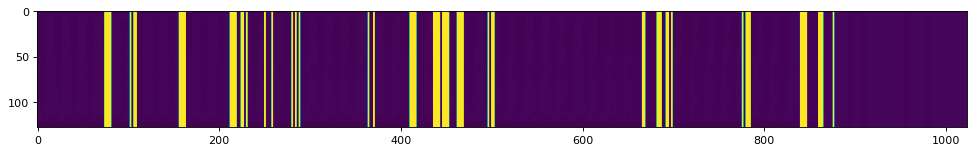

In [27]:
plt.figure(num=1, figsize=(15, 25), dpi=80)
plt.imshow(pred.cpu().transpose(1, 0)[0,0,:,:])
plt.show()

in terms of saving embeddings for the self-supervised portion, I guess it would be the projection from the final block?

In [28]:
import pandas as pd
with torch.no_grad():
    fname_list = []
    embed_list = []
    
    for i, (audio_input, _, fname) in enumerate(test_loader):
        #print(fname)
        B = audio_input.size(0)
        audio_input = audio_input.to(device, non_blocking=True)
        embedding=ast_mdl(audio_input, task='ft_avgtok_embed')
        embedding = embedding.cpu()
        tlist=[]
        tlist.extend(fname[fi] for fi in range(len(fname)))
        fname_arr = tlist
        fname_list.extend(fname_arr)
        embed_arr = embedding.detach().numpy().tolist()
        embed_list.extend(embed_arr)
       

In [29]:
len(embed_list)

20920

In [30]:
proj_df = pd.DataFrame({'filename':fname_list, 'embedding': embed_list})

In [31]:
proj_df.to_parquet('embedding_pretrainedssast_pretrained_alllegacy.parquet',index= False)

___

Demonstration of feature extraction with torch

In [32]:
import torch
import timm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# this fails because AIF security
# deit = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=True)

# so we do pretrained_false and then replace the dictionary
deit = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=False).to(device)

In [33]:
# download the dictionary from here
# 'https://dl.fbaipublicfiles.com/dino/dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth'
# and then upload it

# replace dictionary
load_pretrained_mdl_path='/home/jupyter/ast/deit_base_distilled_patch16_384-d0272ac0.pth'
sd = torch.load(load_pretrained_mdl_path, map_location=device)
deit.load_state_dict(sd['model'], strict=False)

<All keys matched successfully>

In [34]:
deit.eval()

DistilledVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(


There are many cools ways this can be used. I'm just going to extract the final attention map, but have a look at:

 * https://github.com/jacobgil/vit-explain and https://jacobgil.github.io/deeplearning/vision-transformer-explainability
 * https://github.com/hila-chefer/Transformer-Explainability and https://arxiv.org/pdf/2012.09838v1.pdf
 


In [35]:
from typing import Union, Tuple

import cv2
import numpy as np


def center_crop(img: np.ndarray, crop_size: Tuple[int, int]) -> np.ndarray:
    """
    Args:
        img - Image to be cropped
        crop_size - Size of crop. Must be smaller than or equal to the image
            size
    """
    assert (img.shape[0] >= crop_size[0]) and (img.shape[1] >= crop_size[1])
    y0 = img.shape[0] // 2 - crop_size[0] // 2
    y1 = y0 + crop_size[0]
    x0 = img.shape[1] // 2 - crop_size[1] // 2
    x1 = x0 + crop_size[1]
    return img.copy()[y0:y1, x0:x1]

def resize_shortest_edge(
        img: np.ndarray, length: int,
        interpolation: Union[int, str]=cv2.INTER_LINEAR) -> np.ndarray:
    """
    Resize image with locked aspect ratio such that its shortest side is `length`
    pixels long.
    `interpolation` specifies the cv2 interpolation type and defaults to
    cv2.INTER_LINERAR It may be specified as 'auto' in which case either
    cv2.INTER_AREA or cv2.INTERCUBIC is used depnding on whether we are
    downsizing or upsizing (respectively)
    """
    f = length/np.min(img.shape[:2])
    if isinstance(interpolation, str):
        assert interpolation == 'auto', \
            "If `interpolation` is a str it can only be 'auto'"
        interpolation = cv2.INTER_AREA if f < 1 else cv2.INTER_CUBIC
    return cv2.resize(img, (0,0), fx=f, fy=f, interpolation=interpolation)

def prepare_input(img, mean, std):
    img = img/255
    img = img - np.array(mean)
    img = img / np.array(std)
    return torch.tensor(img).permute(2,0,1).unsqueeze(0).float()

In [51]:
img = cv2.imread('trex_bike2.jpg')[..., ::-1]
img = resize_shortest_edge(img, 384, interpolation='auto')
img = center_crop(img, (384, 384))
inps = prepare_input(img, deit.default_cfg['mean'], deit.default_cfg['std'])

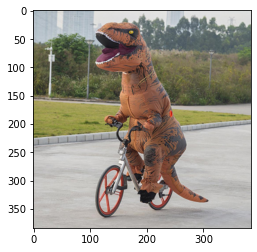

In [52]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [53]:
with torch.no_grad():
    out1 = torch.softmax(deit(inps.to("cuda"))[0],-1).cpu().numpy()

In [54]:
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

In [55]:
top10 = np.argsort(out1, axis=-1)[::-1][:10]
for idx in top10[-10:]:
    print(f'{out1[idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

0.37646 : bicycle-built-for-two, tandem_bicycle, tandem
0.32188 : unicycle, monocycle
0.12880 : mountain_bike, all-terrain_bike, off-roader
0.08086 : crash_helmet
0.02115 : tricycle, trike, velocipede
0.01645 : moped
0.01527 : knee_pad
0.00222 : cowboy_boot
0.00149 : maillot
0.00142 : triceratops


That's interesting and encouraging. 

Here is fx in action:

In [56]:
from torchvision.models.feature_extraction import get_graph_node_names
from pprint import pprint
from timm.models.vision_transformer import PatchEmbed

train_nodes, eval_nodes = get_graph_node_names(deit, tracer_kwargs={'leaf_modules': [PatchEmbed]})

assert([t == e for t, e in zip(train_nodes, eval_nodes)])

pprint(train_nodes)

['x',
 'getattr',
 'getitem',
 'patch_embed',
 'cls_token',
 'expand',
 'dist_token',
 'expand_1',
 'cat',
 'pos_embed',
 'add',
 'pos_drop',
 'blocks.0.norm1',
 'blocks.0.attn.getattr',
 'blocks.0.attn.getitem',
 'blocks.0.attn.getitem_1',
 'blocks.0.attn.getitem_2',
 'blocks.0.attn.qkv',
 'blocks.0.attn.floordiv',
 'blocks.0.attn.reshape',
 'blocks.0.attn.permute',
 'blocks.0.attn.getitem_3',
 'blocks.0.attn.getitem_4',
 'blocks.0.attn.getitem_5',
 'blocks.0.attn.transpose',
 'blocks.0.attn.matmul',
 'blocks.0.attn.mul',
 'blocks.0.attn.softmax',
 'blocks.0.attn.attn_drop',
 'blocks.0.attn.matmul_1',
 'blocks.0.attn.transpose_1',
 'blocks.0.attn.reshape_1',
 'blocks.0.attn.proj',
 'blocks.0.attn.proj_drop',
 'blocks.0.drop_path',
 'blocks.0.add',
 'blocks.0.norm2',
 'blocks.0.mlp.fc1',
 'blocks.0.mlp.act',
 'blocks.0.mlp.drop',
 'blocks.0.mlp.fc2',
 'blocks.0.mlp.drop_1',
 'blocks.0.drop_path_1',
 'blocks.0.add_1',
 'blocks.1.norm1',
 'blocks.1.attn.getattr',
 'blocks.1.attn.getitem'

In [57]:
from torchvision.models.feature_extraction import create_feature_extractor
import random
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.transform import resize
import math
import torch.nn.functional as F

return_nodes = {
    'blocks.11.attn.mul': 'attn1',
    'blocks.11.attn.attn_drop': 'attn2'
}

feat_ext = create_feature_extractor(
    deit, return_nodes=return_nodes,
    tracer_kwargs={'leaf_modules': [PatchEmbed]})

out = feat_ext(inps.to("cuda"))



In [58]:
out['attn1'].shape

torch.Size([1, 12, 578, 578])

In [59]:
out['attn2'].shape

torch.Size([1, 12, 578, 578])

That is
* 1 image / batch size of 1
* 12 heads
* 1 CLS token + 1 distillation token + 576 patches
* 1 CLS token + 1 distillation token + 576 patches

I think the interpretation is that
1,1,1,2:578 = the information from these patches (dim 3) will flow into the cls token (dim 2) for this head (dim 1) for this image (dim 0)

now we can do softmax with temperature on either the average attention across all patches, or the cls token to all patches, etc

In [60]:
ix = 0

with torch.no_grad():
    out = feat_ext(inps.to("cuda"))['attn2']
    # Softmax with temperature
    heat_maps = torch.softmax(out/5, -1)
    # Remove class token, and select cls token
    #heat_maps = heat_maps[...,0:1,2:]
    #heat_maps = torch.mean(heat_maps[...,0:1,2:], dim=1, keepdim=True)
    heat_maps = torch.mean(heat_maps[...,2:,2:],dim=2,keepdim=True)
    #heat_maps = torch.mean(out[...,2:,2:],dim=2,keepdim=True)
    #heat_maps = torch.mean(heat_maps,dim=1,keepdim=True)
    # Deflatten
    edge_length = int(math.sqrt(heat_maps.shape[-1]))
    heat_maps = heat_maps.reshape(-1, 1, edge_length, edge_length)
    # Resize to image shape
    heat_maps = F.interpolate(heat_maps, img.shape[:2], mode='bicubic', align_corners=False)
    heat_maps = list(heat_maps.squeeze(1).cpu().numpy())

In [61]:
out.shape

torch.Size([1, 12, 578, 578])

In [62]:
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap



def overlay_heat_map(
        img: np.ndarray, heat_map: np.ndarray, color=(255, 0, 0)) -> np.ndarray:
    """
    heat_map values should be in [0, 1]
    """
    assert (heat_map.shape[0] == img.shape[0]) and (heat_map.shape[1] == img.shape[1])
    # overlay = np.tile(color, (*img.shape[:2], 1))
    overlay = cm.hot(heat_map)[..., :3] * 255
    heat_map = heat_map[..., None].repeat(3, -1)
    img = (img * (1 - heat_map) + overlay * heat_map).astype(np.uint8)
    return img
    # return overlay.astype(np.uint8)
    
def overlay_black_map(
        img: np.ndarray, heat_map: np.ndarray, color=(255, 0, 0)) -> np.ndarray:
    """
    heat_map values should be in [0, 1]
    """
    assert (heat_map.shape[0] == img.shape[0]) and (heat_map.shape[1] == img.shape[1])
    # overlay = np.tile(color, (*img.shape[:2], 1))
    #overlay = (1-heat_map)[..., :3] * 255
    cmap = np.zeros([256, 4])
    cmap = ListedColormap(cmap)
    overlay = cmap(1-heat_map)[..., :3] * 255
    heat_map = heat_map[..., None].repeat(3, -1)
    img = (img * (heat_map) + overlay * (1-heat_map)).astype(np.uint8)
    return img
    # return overlay.astype(np.uint8)

from typing import Sequence
    
def show_images(ls_img, titles=[], imsize=(7, 5), cmap=None, per_row=2,
                keep_ticks=False, font_size=16):
    """makes a figure with enough subplots to show the images of `ls_img`
    """                
    # make sure ls_img is a list
    if not isinstance(ls_img, Sequence):
        ls_img = [ls_img]

    # make sure titles is a list
    if not isinstance(titles, Sequence):
        titles = [titles]

    # make sure titles is same length as ls_img
    if len(titles):
        assert len(titles) == len(
            ls_img), "Please provide as many titles as there are images"
    else:
        titles = [''] * len(ls_img)

    # prepare figure
    num_rows = len(ls_img) // per_row + ((len(ls_img) % per_row) > 0)
    fig, ax = plt.subplots(num_rows, per_row, figsize=(
        imsize[0] * per_row, imsize[1] * num_rows))
    if type(ax) == np.ndarray:
        ax = ax.flatten()
    else:
        ax = np.array([ax])

    # populate figure
    for i, img in enumerate(ls_img):
        this_cmap = cmap
        if this_cmap is None and (len(img.shape) == 2 or img.shape[-1] == 1):
            this_cmap = 'gray'
        ax[i].imshow(img, cmap=this_cmap, vmin=0, vmax=255)
        ax[i].set_title(titles[i], fontdict={'fontsize': font_size})
        if not keep_ticks:
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    return fig, ax

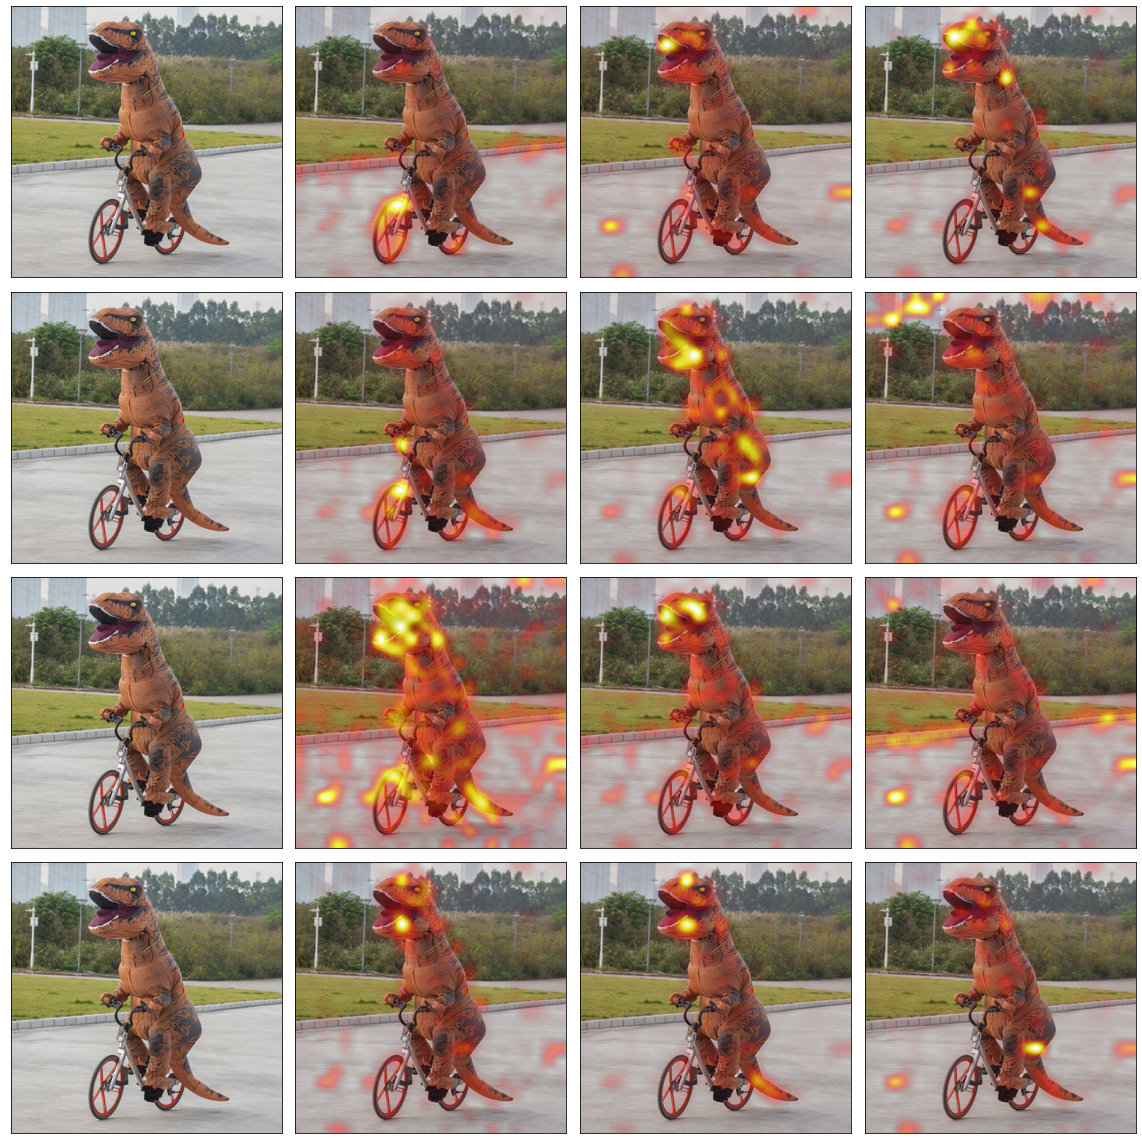

In [63]:
# Scale pixels
heat_maps = [(hm - hm.min()) / (hm.max() - hm.min()) for hm in heat_maps]
heat_map_imgs = [overlay_heat_map(img, heat_map) for heat_map in heat_maps]
heat_map_imgs.insert(9, img)
heat_map_imgs.insert(6, img)
heat_map_imgs.insert(3, img)
heat_map_imgs.insert(0, img)
show_images(heat_map_imgs, per_row=4, imsize=(4, 4));

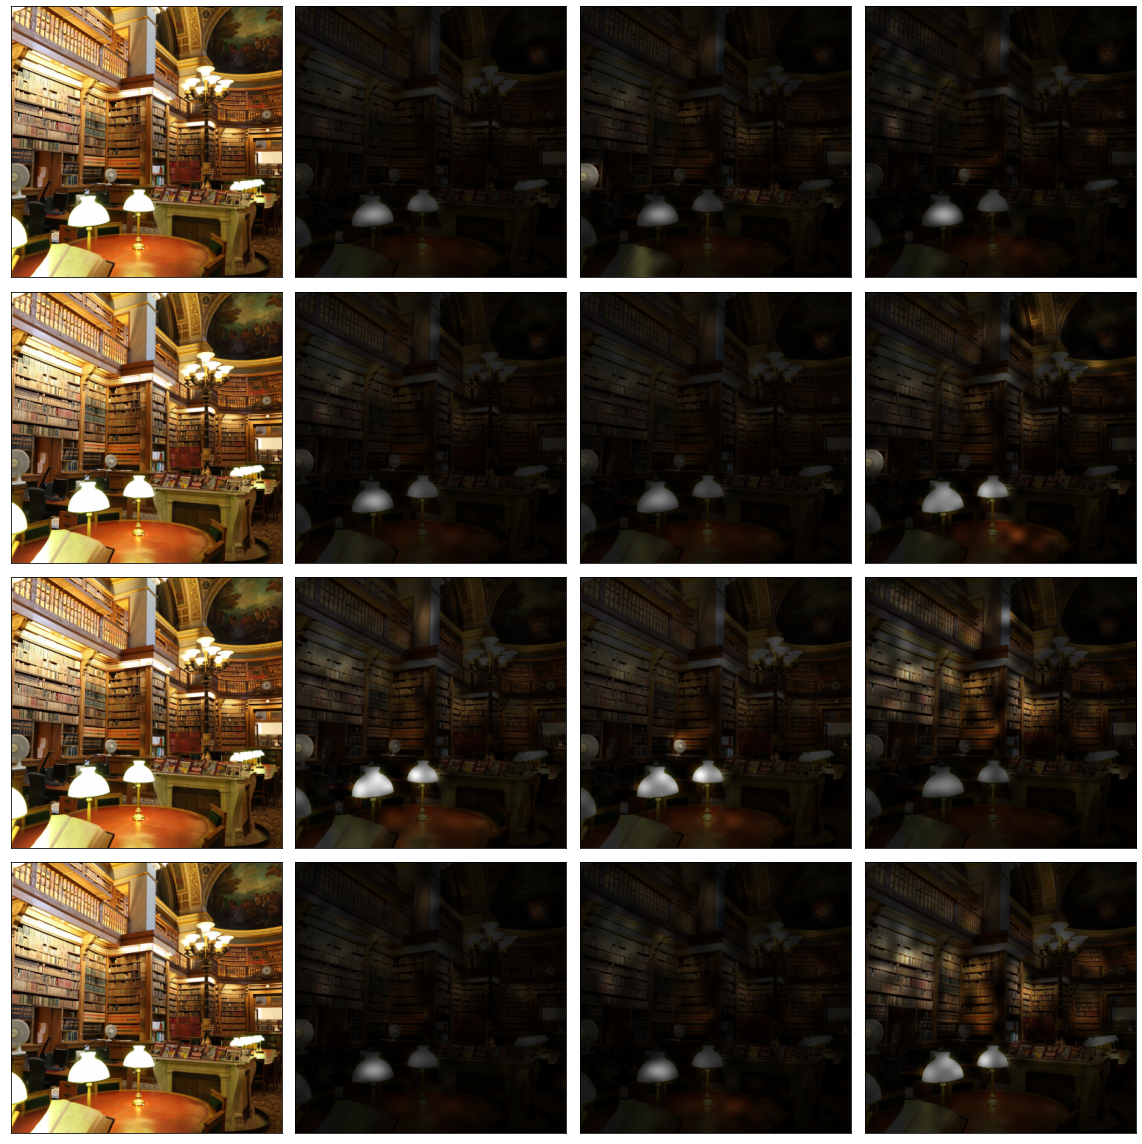

In [49]:
heat_maps = [(hm - hm.min()) / (hm.max() - hm.min()) for hm in heat_maps]
heat_map_imgs = [overlay_black_map(img, heat_map) for heat_map in heat_maps]
heat_map_imgs.insert(9, img)
heat_map_imgs.insert(6, img)
heat_map_imgs.insert(3, img)
heat_map_imgs.insert(0, img)
show_images(heat_map_imgs, per_row=4, imsize=(4, 4));

We should try rollout next